In [ ]:
import os
import cv2
import torch
import numpy as np
import time
import psutil
import sys
from skimage.metrics import structural_similarity as ssim
from torchvision.transforms.functional import to_tensor
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import matplotlib.pyplot as plt

sys.path.append("model-frameflow/project/")

from train_log.RIFE_HDv3 import Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model()

state_dict_path = "model-frameflow/project/train_log/flownet.pkl"
if not os.path.exists(state_dict_path):
    raise FileNotFoundError(f"Model checkpoint not found at {state_dict_path}")

state_dict = torch.load(state_dict_path, map_location=device)
model.flownet.load_state_dict({k.replace("module.", ""): v for k, v in state_dict.items()}, strict=False)
model.flownet.to(device)
model.eval()

def read_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at {image_path}")
    img = cv2.imread(image_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def compute_ssim(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY).astype(np.float32)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY).astype(np.float32)
    return ssim(img1_gray, img2_gray, data_range=255)

def compute_psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    return 20 * np.log10(255.0 / np.sqrt(mse + 1e-10))

def generate_interpolated_frame(img1, img2):
    img1_tensor = to_tensor(img1).unsqueeze(0).to(device)
    img2_tensor = to_tensor(img2).unsqueeze(0).to(device)
    with torch.no_grad():
        interpolated = model.inference(img1_tensor, img2_tensor)
    frame = (interpolated.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    return frame  # Already in RGB format

def recursive_interpolation_adaptive(frame1, frame2, threshold=0.98, depth=0, max_depth=10):
    if depth >= max_depth:
        return []
    mid_frame = generate_interpolated_frame(frame1, frame2)
    sim1, sim2 = compute_ssim(frame1, mid_frame), compute_ssim(mid_frame, frame2)
    
    if sim1 < threshold or sim2 < threshold:
        left_frames = recursive_interpolation_adaptive(frame1, mid_frame, threshold, depth + 1, max_depth)
        right_frames = recursive_interpolation_adaptive(mid_frame, frame2, threshold, depth + 1, max_depth)
        return left_frames + [mid_frame] + right_frames
    return []

def recursive_interpolation_fixed(frame1, frame2, depth=6):
    if depth == 0:
        return []
    mid_frame = generate_interpolated_frame(frame1, frame2)
    left_frames = recursive_interpolation_fixed(frame1, mid_frame, depth - 1)
    right_frames = recursive_interpolation_fixed(mid_frame, frame2, depth - 1)
    return left_frames + [mid_frame] + right_frames

def monitor_resources():
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    time.sleep(0.1)
    return {
        "cpu_usage": psutil.cpu_percent(interval=0.1),
        "gpu_memory_allocated": torch.cuda.memory_allocated() / 1e6 if torch.cuda.is_available() else 0.0,
        "gpu_memory_reserved": torch.cuda.memory_reserved() / 1e6 if torch.cuda.is_available() else 0.0,
        "memory_utilization": psutil.virtual_memory().percent
    }

def generate_video(start_frame_path, end_frame_path, method="adaptive", output_video="output.mp4", fps=30, depth=6):
    start_frame, end_frame = read_image(start_frame_path), read_image(end_frame_path)
    start_time, resources_before = time.time(), monitor_resources()
    
    frames = [start_frame] + (recursive_interpolation_adaptive(start_frame, end_frame) if method == "adaptive" 
                              else recursive_interpolation_fixed(start_frame, end_frame, depth)) + [end_frame]
    
    resources_after, end_time = monitor_resources(), time.time()
    
    ssim_values = [compute_ssim(frames[i], frames[i + 1]) for i in range(len(frames) - 1)]
    psnr_values = [compute_psnr(frames[i], frames[i + 1]) for i in range(len(frames) - 1)]
    
    avg_ssim, avg_psnr = np.mean(ssim_values), np.mean(psnr_values)
    
    clip = ImageSequenceClip(frames, fps=fps)  # Frames are already in RGB
    clip.write_videofile(output_video, codec="libx264", fps=fps)
    
    return {
        "method": method,
        "frames_generated": len(frames),
        "inference_time": end_time - start_time,
        "cpu_usage": resources_after["cpu_usage"],
        "gpu_memory_allocated": resources_after["gpu_memory_allocated"],
        "gpu_memory_reserved": resources_after["gpu_memory_reserved"],
        "avg_ssim": avg_ssim,
        "avg_psnr": avg_psnr
    }

def compare_methods():
    fixed_results = generate_video("img001.png", "img002.png", 
                                   method="fixed", output_video="baseline_video.mp4", depth=6)
    adaptive_results = generate_video("img001.png", "img002.png", 
                                      method="adaptive", output_video="optimized_video.mp4")
    fixed_video_size = os.path.getsize("baseline_video.mp4") / (1024 * 1024)
    adaptive_video_size = os.path.getsize("optimized_video.mp4") / (1024 * 1024)
    
    frames_reduction = (1 - (adaptive_results['frames_generated'] / fixed_results['frames_generated'])) * 100
    time_inc = ((adaptive_results['inference_time'] / fixed_results['inference_time']) - 1) * 100
    storage_reduction = (1 - (adaptive_video_size / fixed_video_size)) * 100

    print("\n🔹 **Comparison:**")
    print(f"   - Frames Generated: Fixed={fixed_results['frames_generated']}, Adaptive={adaptive_results['frames_generated']}")
    print(f"   - Inference Time: Fixed={fixed_results['inference_time']:.4f}s, Adaptive={adaptive_results['inference_time']:.4f}s")
    print(f"   - Frames Reduction: {frames_reduction:.2f}%")
    print(f"   - Inference Time Increase: {time_inc:.2f}%")
    print(f"   - Storage Reduction: {storage_reduction:.2f}%")
    print(f"   - Average SSIM: Fixed={fixed_results['avg_ssim']:.4f}, Adaptive={adaptive_results['avg_ssim']:.4f}")
    print(f"   - Average PSNR: Fixed={fixed_results['avg_psnr']:.2f}dB, Adaptive={adaptive_results['avg_psnr']:.2f}dB")

    return {
        "frames_reduction": frames_reduction,
        "time_increase": time_inc,
        "storage_reduction": storage_reduction,
        "ssim": [fixed_results['avg_ssim'], adaptive_results['avg_ssim']],
        "psnr": [fixed_results['avg_psnr'], adaptive_results['avg_psnr']],
        "methods": ["Fixed", "Adaptive"]
    }


results = compare_methods()



/tmp/ipykernel_31/1804648489.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path, map_location=device)


Moviepy - Building video /kaggle/working/baseline_video.mp4.
Moviepy - Writing video /kaggle/working/baseline_video.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/baseline_video.mp4
Moviepy - Building video /kaggle/working/optimized_video.mp4.
Moviepy - Writing video /kaggle/working/optimized_video.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/optimized_video.mp4

🔹 **Comparison:**
   - Frames Generated: Fixed=65, Adaptive=33
   - Inference Time: Fixed=2.9311s, Adaptive=10.1677s
   - Frames Reduction: 49.23%
   - Inference Time Increase: 246.89%
   - Storage Reduction: 34.92%
   - Average SSIM: Fixed=0.9870, Adaptive=0.9624
   - Average PSNR: Fixed=41.99dB, Adaptive=36.72dB


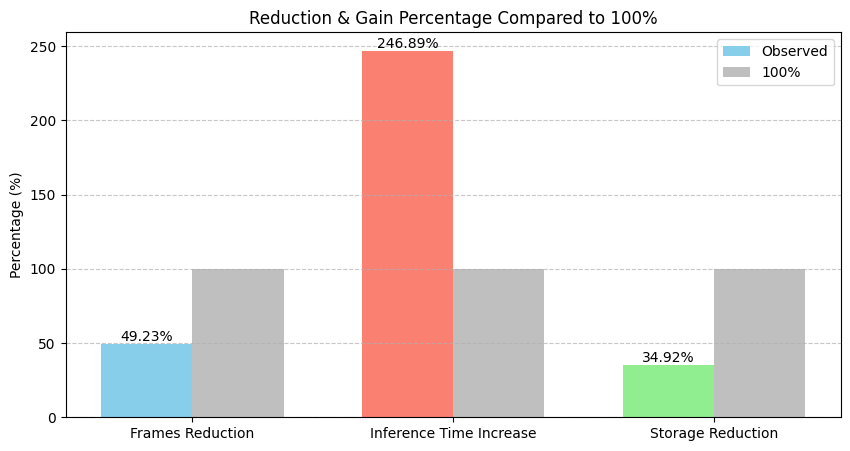

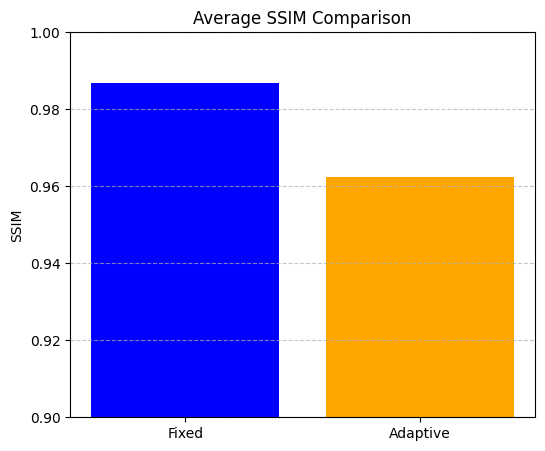

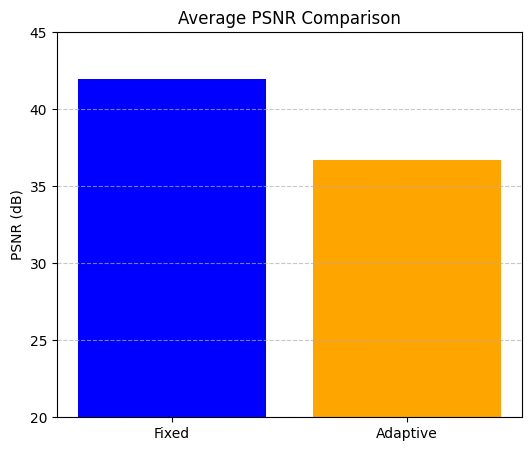

In [ ]:
# Data for plotting
metrics = ["Frames Reduction", "Inference Time Increase", "Storage Reduction"]
values = [results["frames_reduction"], results["time_increase"], results["storage_reduction"]]
total = [100, 100, 100]

ssim_values = results["ssim"]
psnr_values = results["psnr"]
methods = results["methods"]

# Bar chart for Reduction & Gain %, compared to 100%
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, values, width, label="Observed", color=["skyblue", "salmon", "lightgreen"])
bars2 = ax.bar(x + width/2, total, width, label="100%", color="gray", alpha=0.5)

ax.set_ylabel("Percentage (%)")
ax.set_title("Reduction & Gain Percentage Compared to 100%")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}%", ha='center', va='bottom', fontsize=10)

plt.savefig("reduction_gain_comparison.png", dpi=900)
plt.show()

# Zoomed-out SSIM Graph
plt.figure(figsize=(6, 5))
plt.bar(methods, ssim_values, color=["blue", "orange"])
plt.ylabel("SSIM")
plt.title("Average SSIM Comparison")
plt.ylim(0.9, 1)  # Adjusted for better visualization
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("ssim_comparison.png", dpi=900)
plt.show()

# Zoomed-out PSNR Graph
plt.figure(figsize=(6, 5))
plt.bar(methods, psnr_values, color=["blue", "orange"])
plt.ylabel("PSNR (dB)")
plt.title("Average PSNR Comparison")
plt.ylim(20, 45)  # Adjusted for better visualization
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("psnr_comparison.png", dpi=900)
plt.show()